# Data Pre-Processing

**Import Packages and Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
# create dataframe
df = pd.read_csv("data/healthcare-dataset-stroke-data.csv")

In [4]:
# check shape of dataset
print(df.shape)

(5110, 12)


In [5]:
# first 5 rows of dataset
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Cleaning

### Check Null Values

In [6]:
# features with nan value
features_with_na = [column for column in df.columns if df[column].isnull().sum() >= 1]
for feature in features_with_na:
    print(feature, np.round(df[feature].isnull().mean()*100, 5), "% missing values")

bmi 3.93346 % missing values


**Why might a value be missing?**

When considering the potential impact of the missing data on the dataset, it is important to consider the underlying reasons for why the data are missing. We can divide the missing data into 3 categories:
* Missing Completely At Random (MCAR)
* Missing At Random (MAR)
* Missing Not At Random (MNAR)

In our case, it is MCAR type of missing values in the dataset. When we make this assumption, we are assuming the missing data is completely unrelated to the other information in the data.

### Check Duplicate Values

In [8]:
df.duplicated().sum()

np.int64(0)

### Remove "id" from the dataset & "gender", "Residence_type" from the dataset as per EDA report

In [10]:
df.drop(["id", "gender", "Residence_type"], inplace=True, axis=1)

## Feature Engineering

#### Types of Features

**Numeric Features**

In [11]:
numeric_features = [column for column in df.columns if df[column].dtype != 'O']
print("Number of Numerical Features:", len(numeric_features))
numeric_features

Number of Numerical Features: 6


['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

**Categorical Features**

In [12]:
categorical_features = [column for column in df.columns if df[column].dtype == 'O']
print("Number of Categorical Features:", len(categorical_features))
categorical_features

Number of Categorical Features: 3


['ever_married', 'work_type', 'smoking_status']

**Discrete Features**

In [13]:
discrete_features = [feature for feature in numeric_features if (len(df[feature].unique())<=25)]
print("Number of Discrete Features:", len(discrete_features))
discrete_features

Number of Discrete Features: 3


['hypertension', 'heart_disease', 'stroke']

**Continuous Features**

In [14]:
continuous_features = [feature for feature in numeric_features if len(df[feature].unique()) > 25]
print("Number of Continuous Features: ", len(continuous_features))
continuous_features

Number of Continuous Features:  3


['age', 'avg_glucose_level', 'bmi']

#### Impute Null Values with Median value

* As the distribution of 

In [15]:
# create copy of dataframe & impute null values with median value
df1 = df.copy()
for feature in continuous_features:
    df1[feature].fillna(df1[feature].median(), inplace=True)

#### Multicollinearity Check

**Variance Inflation Factor (VIF)**

* Multicollinearity occurs when there are two or more independent variables having high correlation among themselves.
* Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor (VIF).

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(considered_features, df):
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X["intercept"] = 1

    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif["Variable"] != "intercept"]
    return vif

In [17]:
compute_vif(continuous_features, df1)

,Variable,VIF
0,age,1.162810
1,avg_glucose_level,1.070325
2,bmi,1.128268


* VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.
* VIF above 5 is an indicator of Multicollinearity.

In our case, there is no multicollinearity.

#### Handle Outliers

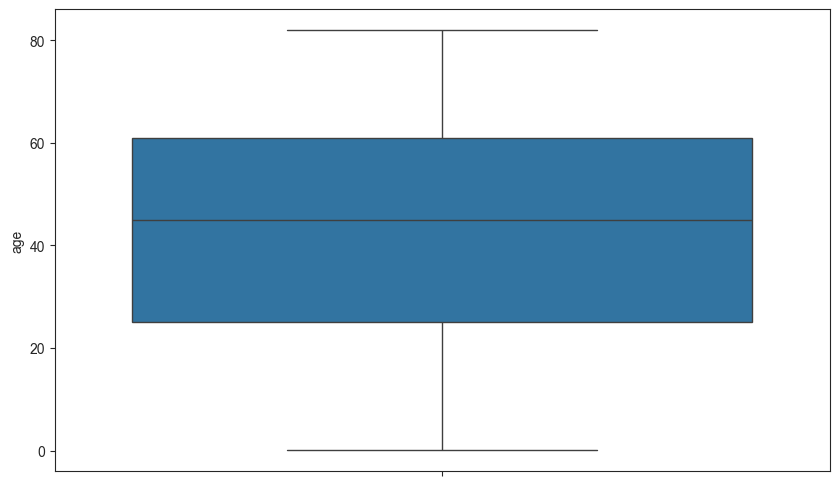

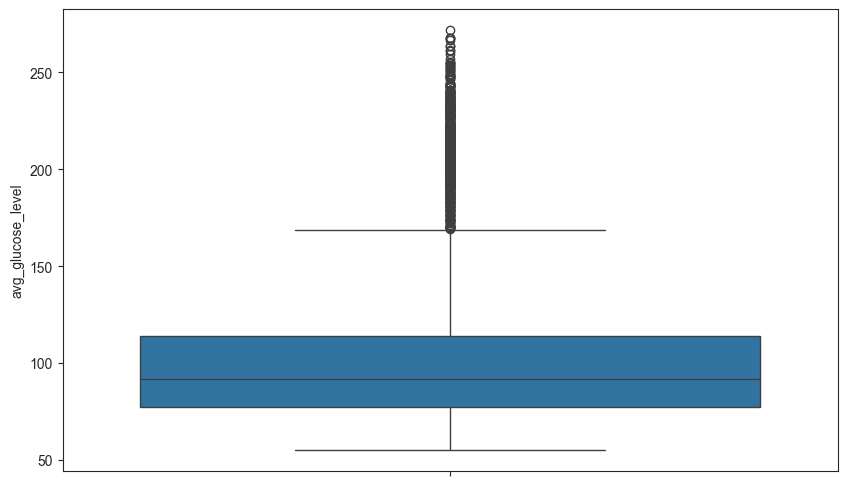

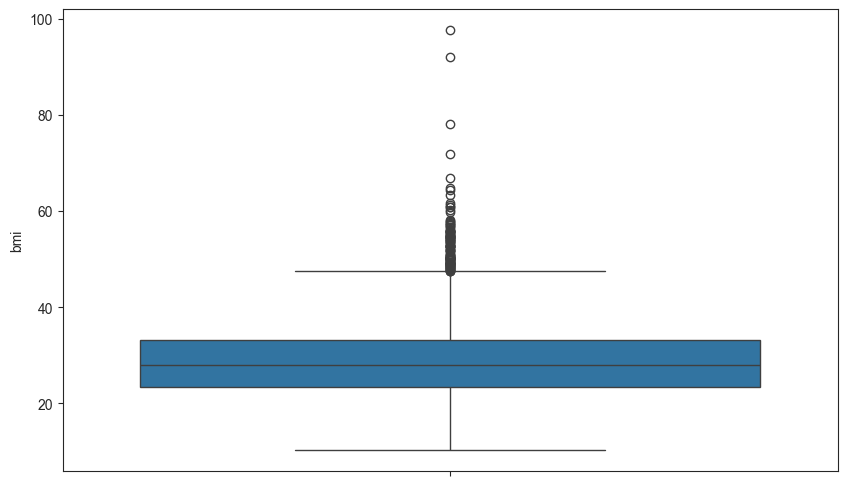

In [18]:
for i in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.set_style("ticks")
    ax = sns.boxplot(df[i])

**Outlier removal using standard deviation procedure**

* Usually z-score = 3 is considered as a cut-off value to set the limit. Any z-score greater than +3 or less than -3 is considered as outlier which ispretty much similar to standard deviation method.
* Here we can remove outliers after 3rd standard deviation or z-score +3 and -3.

In [19]:
def outlier_removal(column, df):
    upper_limit = df[column].mean() + 3*df[column].std()
    lower_limit = df[column].mean() - 3*df[column].std()
    df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df

In [20]:
df.shape

(5110, 9)

In [21]:
outlier_feature = ["bmi"]

In [22]:
for i in range(len(outlier_feature)):
    df = outlier_removal(outlier_feature[i], df)

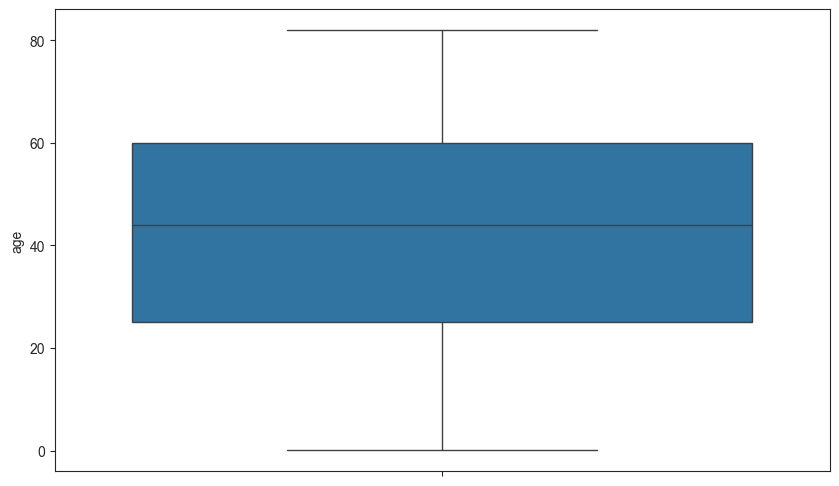

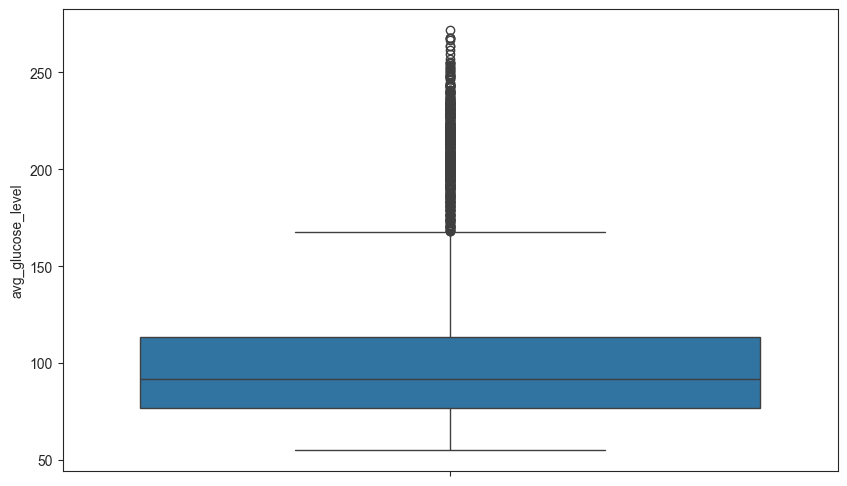

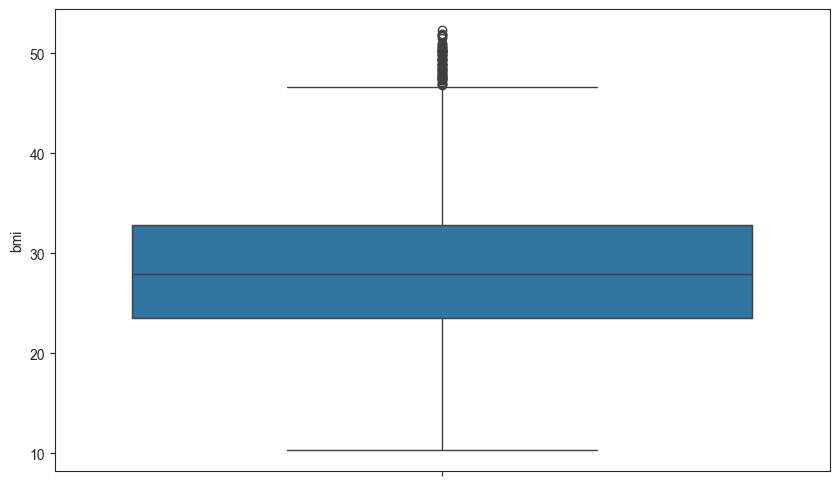

In [23]:
for i in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.set_style("ticks")
    ax = sns.boxplot(df[i])

In [24]:
df.shape

(4851, 9)

#### Feature Transformation

* If Skewness is above 2, then the feature is Highly skewed.
* If Skewness is above 1.5, then the feature is moderately skewed.

In [25]:
df[continuous_features].skew(axis=0)

age                 -0.115593
avg_glucose_level    1.626970
bmi                  0.466922
dtype: float64

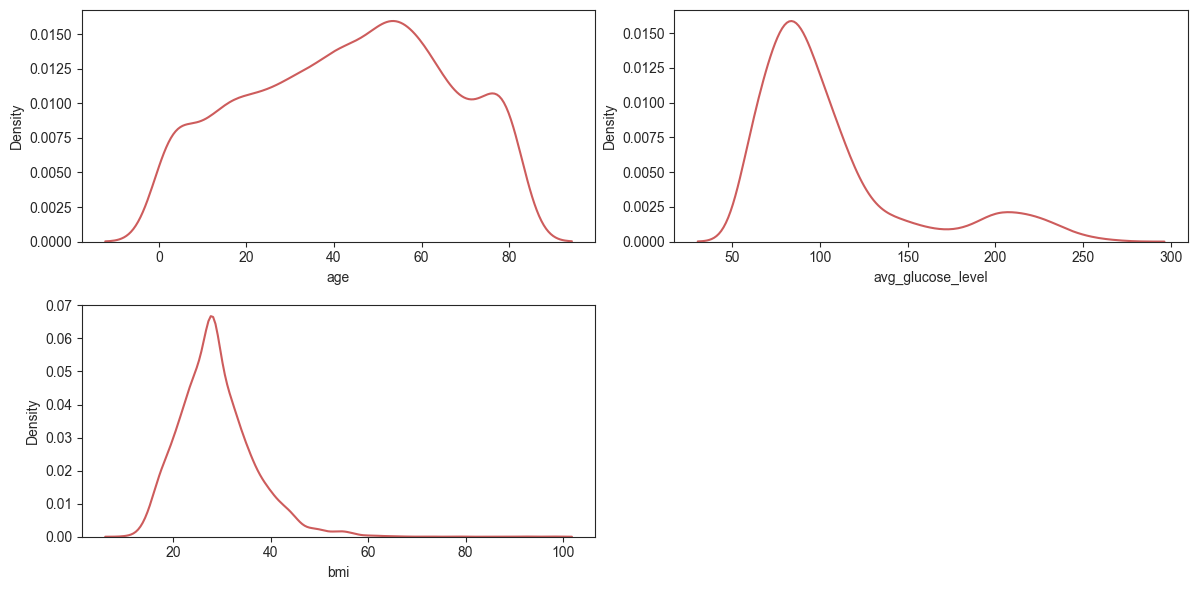

In [26]:
# distribution of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x=df1[col], color="indianred")
    plt.xlabel(col)
    plt.tight_layout()

* `avg_glucose_level` is slightly skewed.
* `age` has kutosis and it is platykurtic.
* `bmi` is normally distributed with very little data on its tails.

#### Split X and y

In [27]:
from sklearn.model_selection import train_test_split
X = df.drop(["stroke"], axis=1)
y = df["stroke"]

In [28]:
for feature in categorical_features:
    print(feature, ":", X[feature].nunique())

ever_married : 2
work_type : 5
smoking_status : 4


#### Feature Encoding and Scaling

**One Hot Encoding for columns having lesser unique values and non-ordinal in nature:**

In [29]:
for i in continuous_features:
    print(f"{i}: mean = {df[i].mean():.2f}, median = {df[i].median():.2f}")

age: mean = 42.83, median = 44.00
avg_glucose_level: mean = 105.10, median = 91.68
bmi: mean = 28.54, median = 27.90


* **Mean Imputer:** There are no missing values in `age` and `avg_glucose_level` and only `bmi` column should be handled. Based on the above result we can impute the column with either mean or median. Since we handled outlier for the continuous features, the mean and median of the features are nearly same. When there are no outliers mean will perform as a better imputer.
* **Standardscaler:** As most of our features are near normally distributed, we will perform standard scaling to scale the data.
* **Power Transformer:** Since `avg_glucose_level` was right skewed, we will use Power Transformer to transform it.

In [30]:
# create column Transformer with 3 types of transformers
categorical_features = X.select_dtypes(include="object").columns
num_feature = numeric_features.copy()
num_feature.remove("stroke")
transform_features = ["avg_glucose_level"]

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")),
                                   ("scaler", StandardScaler())])

categorical_pipeline = Pipeline(steps=[("one_hot_encoder", OneHotEncoder()),
                                       ("scaler", StandardScaler(with_mean=False))])

transform_pipe = Pipeline(steps=[("transformer", PowerTransformer(standardize=True))])

preprocessor = ColumnTransformer([("numeric_Pipeline", numeric_pipeline, num_feature),
                                  ("categorical_Pipeline", categorical_pipeline, categorical_features),
                                  ("Power_Transformation", transform_pipe, transform_features)])

In [31]:
X = preprocessor.fit_transform(X)

#### Handle Imbalanced Data

* We will handle the imbalanced Target Variable.
* Synthetic Minority Oversampling Technique or SMOTE is another technique to oversample the minority class. Simply adding duplicate records or minority class often don't add any new information to the model.
* SMOTE is one of the famous oversampling techniques and is very effective in handling class imbalance. The idea is to combine SMOTE with some undersampling techniques (ENN, Tomek) to increase the effectiveness of handling the imbalanced class.

`SMOTE+ENN` is one of such hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space. This method combines the SMOTE ability to generate synthetic data for minority class and uses ENN to remove overlapping observation of both the classes.

**To add new data of minority class**
1. Choose random data from the minority class.
2. Calculate the distance between the random data and its k nearest neighbors.
3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
4. Repeat step number 2-3 until the desired proportion of minority class is met.

**To remove the data points of both classes**
1. Determine K, as the number of nearest neighbors. If not determined, then K=3.
2. Find the K-nearest neighbor of the observation among the other observations in the dataset, then return the majority class from the K-nearest neighbor.
3. If the class of the observation and the majority class from the observation's K-nearest neighbor is difficult, then the observation and its K-nearest neighbor are deleted from the dataset.
4. Repeat step 2 and 3 until the desired proportion of each class is fulfilled.

* This method, instead of adding duplicate data, synthesises the new data based on the already available classes. Hence, we choose this as our imputer method for this problem.